**기후 변화에 따른 쌀 생산량 분석 및 예측**<br>
(3-A)202244035<br>
이승예

In [ ]:
# 단계 1: 폰트 설치
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

In [2]:
import pandas as pd
import numpy as np
from typing import List, Optional, Dict, Tuple
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

class DataProcessor:
    """쌀 생산량과 기후 데이터를 처리하는 클래스

    주요 기능:
    1. 쌀 생산량 데이터 전처리 및 구조화
    2. 기후 데이터(연간/월간) 전처리 및 정규화
    3. 결측치 처리 및 데이터 보간
    4. 지역별 데이터 매핑 및 필터링

    주요 처리 과정:
    1. Excel/CSV 파일에서 데이터 로드
    2. 결측치 처리 및 데이터 정규화
    3. 지역별 데이터 매핑 및 통계 계산
    4. 처리된 데이터를 파일로 저장
    """

    # 소수점 정밀도 설정 (모든 수치형 데이터는 소수점 첫째자리까지 표현)
    DECIMAL_PRECISION = 1


    # 모든 기후 관련 처리에서 일관되게 사용되는 지표들
    CLIMATE_METRICS = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']


    # 원본 기후 데이터의 컬럼명을 일관된 형식으로 변환하기 위한 딕셔너리
    # 연간('annual')과 월간('monthly') 데이터의 컬럼명이 서로 다르므로 통일된 형식으로 변환
    CLIMATE_COLUMNS = {
        'annual': {
            '평균기온(°C)합계': '평균기온(°C)',
            '강수량(mm)': '합계 강수량(mm)',
            '평균 상대습도(%)합계': '평균 상대습도(%)',
            '일조시간(hr)': '합계 일조시간(hr)'
        },
        'monthly': {
            '평균기온(°C)': '평균기온(°C)',
            '평균상대습도(%)': '평균 상대습도(%)',
            '월합강수량(00~24h만)(mm)': '합계 강수량(mm)',
            '합계 일조시간(hr)': '합계 일조시간(hr)'
        }
    }

    # 지역별 행정구역 매핑
    # 지점명을 광역시도 단위로 그룹화하기 위한 딕셔너리
    # 키: 지점명, 값: 해당 지점이 속한 광역시도
    REGION_MAPPING = {
        # 전라남도 지역
        '목포': '전라남도', '여수': '전라남도', '순천': '전라남도',
        '완도': '전라남도', '진도(첨찰산)': '전라남도', '진도군': '전라남도',
        '해남': '전라남도', '고흥': '전라남도', '광양시': '전라남도',
        '보성군': '전라남도', '강진군': '전라남도', '장흥': '전라남도',

        # 충청남도 지역
        '서산': '충청남도', '천안': '충청남도', '보령': '충청남도',
        '부여': '충청남도', '홍성': '충청남도',

        # 전라북도 지역
        '전주': '전라북도', '군산': '전라북도', '부안': '전라북도',
        '임실': '전라북도', '정읍': '전라북도', '남원': '전라북도',
        '장수': '전라북도', '고창군': '전라북도', '순창군': '전라북도',

        # 경상북도 지역
        '포항': '경상북도', '안동': '경상북도', '상주': '경상북도',
        '울진': '경상북도', '봉화': '경상북도', '영주': '경상북도',
        '문경': '경상북도', '청송군': '경상북도', '영덕': '경상북도',
        '의성': '경상북도', '구미': '경상북도', '영천': '경상북도',
        '경주시': '경상북도'
    }

    def __init__(self, target_regions: List[str]):
        self.target_regions = target_regions

    def _calculate_location_means(self, df: pd.DataFrame,group_by: str, columns: List[str], is_monthly: bool = False) -> Dict:
        """
        지역별 평균값 계산

        Notes:
        - 월별 데이터의 경우 각 월별로 개별 평균 계산
        - 특정 월의 데이터가 없는 경우 전체 평균으로 대체
        """
        if is_monthly:
            means = {}
            for col in columns:
                if col in df.columns:
                    monthly_means = {}
                    for month in range(1, 13):
                        month_data = df[df['일시'].str.endswith(f'-{month:02d}')][col]
                        monthly_means[month] = (
                            month_data.mean() if not month_data.empty
                            else df[col].mean()
                        )
                    means[col] = monthly_means
            return means
        else:
            return {
                col: df[col].mean()
                for col in columns
                if col in df.columns
            }

    def _sort_dataframe(self, df: pd.DataFrame, location_col: str) -> pd.DataFrame:
        """데이터프레임 정렬을 위한 통일된 메서드"""
        return df.sort_values([location_col, '일시']).reset_index(drop=True)

    def fill_missing_years(self, df: pd.DataFrame, start_year: int = 2008,
                          end_year: int = 2023) -> pd.DataFrame:
        """
        2008-2023년 범위의 누락된 연도 데이터를 보간하는 함수

        Args:
            df (pd.DataFrame): 처리할 데이터프레임
            start_year (int): 시작 연도 (기본값: 2008)
            end_year (int): 종료 연도 (기본값: 2023)

        Returns:
            pd.DataFrame: 결측치가 보간된 데이터프레임

        처리 과정:
        1. 각 지역별로 누락된 연도/월 확인
        2. 해당 지역의 평균값으로 결측치 대체
        3. 월별 데이터의 경우 동일 월의 평균값으로 대체 (계절성 고려)
        4. 데이터의 일관성을 위해 소수점 첫째자리까지 표준화

        Notes:
            - 월별 데이터의 경우 YYYY-MM 형식으로 처리
            - 연간 데이터의 경우 YYYY 형식으로 처리
            - 결측치는 해당 지역의 평균값으로 대체
        """
        result_df = []
        is_monthly = isinstance(df['일시'].iloc[0], str) and '-' in str(df['일시'].iloc[0])

        for location in df['지점명'].unique():  # 각 지역별로 반복
            location_data = df[df['지점명'] == location].copy()
            location_code = location_data['지점'].iloc[0]

            if is_monthly: # 월별 데이터 처리
                existing_dates = location_data['일시'].unique()
                all_dates = [
                    f"{year}-{month:02d}"
                    for year in range(start_year, end_year + 1)
                    for month in range(1, 13)
                ]

                location_means = self._calculate_location_means( # 지역별 월별 평균 계산
                    location_data, '지점명', self.CLIMATE_METRICS, is_monthly=True
                )

                missing_dates = [date for date in all_dates if date not in existing_dates] # 누락된 날짜 식별
                for date in missing_dates:
                    year, month = map(int, date.split('-')) # 년월 분리
                    new_row = { # 새로운 행 생성
                        '지점': location_code,
                        '지점명': location,
                        '일시': date,
                        **{col: location_means[col][month] # 월별 평균값으로 채움
                           for col in self.CLIMATE_METRICS
                           if col in location_data.columns}
                    }
                    result_df.append(new_row)
            else:  # 연간 데이터 처리
                existing_years = location_data['일시'].astype(int).unique()
                all_years = list(range(start_year, end_year + 1))

                location_means = self._calculate_location_means( # 지역별 평균 계산
                    location_data, '지점명', self.CLIMATE_METRICS
                )

                missing_years = [year for year in all_years if year not in existing_years] # 누락 연도 식별
                for year in missing_years:
                    new_row = { # 새로운 행 생성
                        '지점': location_code,
                        '지점명': location,
                        '일시': year,
                        **location_means # 평균값으로 채움
                    }
                    result_df.append(new_row)

            result_df.extend(location_data.to_dict('records'))

        result_df = pd.DataFrame(result_df)
        result_df['지점'] = result_df['지점'].astype(int)

        result_df = self._sort_dataframe(result_df, '지점명')
        for col in self.CLIMATE_METRICS:
            if col in result_df.columns:
                result_df[col] = result_df[col].round(self.DECIMAL_PRECISION)

        return result_df

    def process_rice_data(self, file_path: Path, output_path: Optional[Path] = None) -> pd.DataFrame:
        """
        쌀 생산량 데이터를 처리하는 메인 함수

        처리 과정:
        1. Excel 파일에서 데이터 로드
        2. 연도별 재배면적과 생산량 데이터 추출
        3. 데이터 재구조화 (Long format으로 변환)
        4. 대상 지역 필터링 및 정렬
        """
        try:
            raw_data = pd.read_excel(file_path)
        except Exception as e:
            raise ValueError(f"Excel 파일 읽기 실패: {str(e)}")

        # 연도 컬럼 추출 (숫자로 된 컬럼명만 선택)
        years = [int(col) for col in raw_data.columns[1:] if str(col).isdigit()]
        unique_years = sorted(set(years))

        # 데이터 재구조화
        restructured_data = []
        for idx, row in raw_data.iloc[2:].iterrows():
            region_name = row.iloc[0]
            for i, year in enumerate(unique_years):
                # 각 연도별로 재배면적과 생산량이 2개 컬럼씩 존재
                area_idx = i * 2 + 1   # 재배면적 컬럼 인덱스
                prod_idx = i * 2 + 2   # 생산량 컬럼 인덱스

                try:
                    restructured_data.append({
                        '행정구역': region_name,
                        '일시': year,
                        '재배면적(ha)': row.iloc[area_idx],
                        '생산량(톤)': row.iloc[prod_idx]
                    })
                except (ValueError, IndexError):
                    continue

        # 대상 지역 필터링 및 정렬
        processed_df = pd.DataFrame(restructured_data)
        processed_df = self._filter_and_sort_data(processed_df)

        if output_path:
            processed_df.to_excel(output_path, index=False)

        return processed_df

    def process_climate_data(
        self,
        annual_path: Path,
        monthly_path: Path
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        연간/월간 기후 데이터를 처리하는 메인 함수

        처리 과정:
        1. CSV 파일에서 데이터 로드 (EUC-KR 인코딩)
        2. 결측 연도/월 데이터 보간
        3. 컬럼명 통일 및 행정구역 정보 추가
        4. 결측치 처리 (지역별 평균으로 대체)

        Notes:
            - 연간/월간 데이터는 서로 다른 컬럼명 사용
            - CLIMATE_COLUMNS 매핑을 통해 컬럼명 통일
            - 모든 수치는 소수점 첫째자리까지 표현
        """
        annual_climate = pd.read_csv(annual_path, encoding='euc-kr')
        monthly_climate = pd.read_csv(monthly_path, encoding='euc-kr')

        annual_climate = self.fill_missing_years(annual_climate)
        monthly_climate = self.fill_missing_years(monthly_climate)

        annual_climate = self._prepare_climate_data(annual_climate, 'annual')
        monthly_climate = self._prepare_climate_data(monthly_climate, 'monthly')

        annual_climate = self.fill_missing_climate_data(annual_climate)
        monthly_climate = self.fill_missing_climate_data(monthly_climate)

        return annual_climate, monthly_climate

    def _filter_and_sort_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        데이터프레임을 필터링하고 정렬하는 헬퍼 메서드

        Notes:
            - target_regions에 포함된 지역만 필터링
            - 행정구역과 시간순으로 정렬
        """
        if self.target_regions:
            df = df[df['행정구역'].isin(self.target_regions)]
        return self._sort_dataframe(df, '행정구역')

    def _prepare_climate_data(self, df: pd.DataFrame, data_type: str) -> pd.DataFrame:
        """
        기후 데이터 전처리를 위한 헬퍼 메서드

        처리 과정:
        1. 컬럼명을 통일된 형식으로 변경
        2. 지점명을 행정구역으로 매핑
        3. 대상 지역만 필터링

        Notes:
            - CLIMATE_COLUMNS 딕셔너리를 통해 컬럼명 변환
            - REGION_MAPPING 딕셔너리를 통해 지역 매핑
        """
        df = df.rename(columns=self.CLIMATE_COLUMNS[data_type])
        df['행정구역'] = df['지점명'].map(self.REGION_MAPPING)
        return df[df['행정구역'].isin(self.target_regions)]

    def fill_missing_climate_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        기후 데이터의 결측치를 처리하는 헬퍼 메서드

        처리 과정:
        1. 빈 문자열을 NaN으로 변환
        2. 숫자형으로 변환 불가능한 값을 NaN으로 처리
        3. 각 지역별 평균값으로 NaN 대체
        4. 소수점 첫째자리까지 반올림

        Notes:
            - CLIMATE_METRICS에 정의된 컬럼만 처리
            - 지역별로 평균을 계산하여 결측치 대체
            - 모든 수치를 DECIMAL_PRECISION 자리까지 반올림
        """
        df_filled = df.copy()

        for col in self.CLIMATE_METRICS:
            if col in df.columns:
                df_filled[col] = pd.to_numeric(
                    df_filled[col].replace('', np.nan),
                    errors='coerce'
                )
                region_means = (df_filled.groupby('행정구역')[col]
                              .transform('mean')
                              .round(self.DECIMAL_PRECISION))
                df_filled[col] = (df_filled[col]
                                .fillna(region_means)
                                .round(self.DECIMAL_PRECISION))
        return df_filled


def main():
    """메인 실행 함수"""
    # 파일 경로 설정
    rice_file = Path('/content/전국_시군별_논벼_생산량.xlsx')
    annual_climate_file = Path('/content/연간기후전체지역.csv')
    monthly_climate_file = Path('/content/월별기후전체지역.csv')

    # 타겟 지역 설정
    target_regions = ['전라남도', '충청남도', '전라북도', '경상북도']

    # 데이터 프로세서 인스턴스 생성
    processor = DataProcessor(target_regions)

    try:
        # 1. 쌀 생산량 데이터 처리
        rice_data = processor.process_rice_data(
            rice_file,
            Path('filtered_rice_production.xlsx')
        )

        # 2. 기후 데이터 처리
        annual_climate, monthly_climate = processor.process_climate_data(
            annual_climate_file,
            monthly_climate_file
        )

        # 3. 처리된 기후 데이터 저장
        annual_climate.to_csv('filtered_climate_annual_data.csv',
                            index=False, encoding='utf-8-sig')
        monthly_climate.to_csv('filtered_climate_monthly_data.csv',
                             index=False, encoding='utf-8-sig')

        print("모든 데이터 처리가 완료되었습니다.")

    except Exception as e:
        print(f"처리 중 오류가 발생했습니다: {str(e)}")

if __name__ == "__main__":
    main()

모든 데이터 처리가 완료되었습니다.


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class RiceProductionAnalyzer:
    """쌀 생산량 분석을 위한 클래스"""

    def __init__(self):
        """데이터 로드 및 초기화"""
        print("\n🌾 쌀 생산량 분석 시스템을 초기화합니다...")
        self.rice_data = pd.read_excel('/content/filtered_rice_production.xlsx')
        self.climate_annual = pd.read_csv('/content/filtered_climate_annual_data.csv')
        self.climate_monthly = pd.read_csv('/content/filtered_climate_monthly_data.csv')
        self.processed_data = None
        self.region_colors = {
            '전라남도': '#1f77b4',  # 파란색
            '충청남도': '#2ca02c',  # 초록색
            '전라북도': '#ff7f0e',  # 주황색
            '경상북도': '#d62728'   # 빨간색
        }
        print("✅ 데이터 로드 완료\n")
        self.prepare_data()

    def prepare_data(self):
        """데이터 전처리"""
        # 날짜 형식 통일
        self._unify_date_formats()
        # 월별 기후 데이터 피봇 및 병합
        monthly_pivot = self._create_monthly_pivot()
        # 최종 데이터 병합
        self._merge_all_data(monthly_pivot)

    def _unify_date_formats(self):
        """날짜 형식 통일화"""
        self.climate_annual['일시'] = self.climate_annual['일시'].astype(int)
        self.climate_monthly['연도'] = self.climate_monthly['일시'].str.split('-').str[0].astype(int)
        self.climate_monthly['월'] = self.climate_monthly['일시'].str.split('-').str[1].astype(int)

    def _create_monthly_pivot(self):
        """월별 기후 데이터 피봇 테이블 생성"""
        pivot = self.climate_monthly.pivot_table(
            index=['행정구역', '연도'],
            columns='월',
            values=['평균기온(°C)', '평균 상대습도(%)', '합계 강수량(mm)', '합계 일조시간(hr)']
        ).reset_index()

        # 컬럼명 재구성
        pivot.columns = [f"{col[0]}_{col[1]}월" if isinstance(col, tuple) and col[1] != ""
                        else col[0] for col in pivot.columns]
        return pivot.rename(columns={'연도': '일시'})

    def _merge_all_data(self, monthly_pivot):
        """모든 데이터 병합"""
        merged_data = pd.merge(
            self.rice_data,
            self.climate_annual[['행정구역', '일시', '평균기온(°C)', '합계 강수량(mm)',
                               '평균 상대습도(%)', '합계 일조시간(hr)']],
            on=['행정구역', '일시']
        )
        self.processed_data = pd.merge(merged_data, monthly_pivot, on=['행정구역', '일시'])

    def analyze_production_changes(self):
        """생산량 변화율 분석 및 시각화"""
        # 기준년도(2008) 대비 변화율 계산
        self.rice_data['단위면적당생산량'] = (self.rice_data['생산량(톤)'] /
                                            self.rice_data['재배면적(ha)']).round(2)
        pivot_data = self.rice_data.pivot(index='일시', columns='행정구역', values='단위면적당생산량')
        change_ratio = (pivot_data / pivot_data.iloc[0] * 100 - 100).reset_index()
        base_production = pivot_data.iloc[0].round(2)

        # 데이터 재구성
        change_ratio_long = pd.melt(change_ratio,
                                  id_vars=['일시'],
                                  var_name='행정구역',
                                  value_name='변화율')

        # 범례 텍스트 생성
        custom_legend = {region: f"{region} (2008년: {base_production[region]:,.2f}톤/ha)"
                        for region in pivot_data.columns}

        return self._create_production_change_plot(change_ratio_long, custom_legend)

    def _create_production_change_plot(self, data, custom_legend):
        """생산량 변화 그래프 생성"""
        fig = px.line(data,
                     x='일시',
                     y='변화율',
                     color='행정구역',
                     title='2008년 대비 지역별 쌀 생산량 변화율 (%)',
                     labels={'변화율': '변화율 (%)', '일시': '연도'},
                     markers=True,
                     color_discrete_map=self.region_colors)

        # 그래프 스타일 설정
        for trace in fig.data:
            trace.name = custom_legend[trace.name]
            trace.line.width = 3
            trace.marker.size = 8

        fig.update_layout(
            height=600,
            width=1000,
            yaxis_tickformat='.1f',
            legend_title_text='지역 (2008년 기준 생산량)',
            template='plotly_white',
            font=dict(family='Noto Sans KR', size=12),
            title=dict(font=dict(size=20, color='black'), x=0.5, y=0.95),
            legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99,
                       bgcolor='rgba(255, 255, 255, 0.8)'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            xaxis=self._get_axis_style(),
            yaxis=self._get_axis_style()
        )
        return fig

    def _get_axis_style(self):
        """축 스타일 설정"""
        return dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            title_font=dict(size=14),
            tickfont=dict(size=12)
        )

    def analyze_regional_comparison(self):
        """지역별 생산 특성 비교 분석"""
        stats_df = self._calculate_regional_stats()
        return self._create_regional_comparison_plot(stats_df)

    def _calculate_regional_stats(self):
        """지역별 통계 계산"""
        stats_df = self.rice_data.groupby(['행정구역', '일시']).agg({
            '재배면적(ha)': 'sum',
            '생산량(톤)': 'sum'
        }).reset_index()
        stats_df['단위면적당생산량'] = (stats_df['생산량(톤)'] /
                                      stats_df['재배면적(ha)']).round(2)
        return stats_df

    def _create_regional_comparison_plot(self, stats_df):
        """지역별 비교 그래프 생성"""
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=('지역별 재배면적 (ha)',
                          '지역별 총 생산량 (톤)',
                          '지역별 단위면적당 생산량 (톤/ha)')
        )

        measures = ['재배면적(ha)', '생산량(톤)', '단위면적당생산량']
        for i, measure in enumerate(measures, 1):
            for region in stats_df['행정구역'].unique():
                region_data = stats_df[stats_df['행정구역'] == region]
                fig.add_trace(
                    go.Box(
                        y=region_data[measure],
                        name=region,
                        boxpoints='all',
                        pointpos=0,
                        marker_color=self.region_colors[region],
                        line_color=self.region_colors[region],
                        showlegend=(i == 1)
                    ),
                    row=1, col=i
                )

        fig.update_layout(
            height=600,
            width=1500,
            title_text="지역별 쌀 생산 특성 비교 (2008-2023)",
            showlegend=True
        )

        for i, measure in enumerate(measures, 1):
            fig.update_yaxes(title_text=measure, row=1, col=i)

        return fig

    def analyze_climate_vulnerability(self):
        """지역별 기후 취약성 분석"""
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
        vulnerability_metrics = {}

        for region in self.processed_data['행정구역'].unique():
            region_data = self.processed_data[self.processed_data['행정구역'] == region]

            # 각 기후 변수의 변동계수(CV) 계산
            cv_metrics = {}
            for var in climate_vars:
                cv = region_data[var].std() / region_data[var].mean()
                cv_metrics[f'{var}_CV'] = cv

            # 생산량 변동성
            unit_production = region_data['생산량(톤)'] / region_data['재배면적(ha)']
            production_cv = unit_production.std() / unit_production.mean()
            cv_metrics['단위면적당생산량_CV'] = production_cv  # 이름도 함께 변경

            vulnerability_metrics[region] = cv_metrics

        vulnerability_df = pd.DataFrame(vulnerability_metrics).T

        # Plotly 히트맵 생성
        fig = go.Figure(data=go.Heatmap(
            z=vulnerability_df.values,
            x=vulnerability_df.columns,
            y=vulnerability_df.index,
            text=np.round(vulnerability_df.values, 3),
            texttemplate='%{text}',
            textfont={"size": 10},
            hoverongaps=False,
            colorscale='YlOrRd',
            colorbar=dict(title='변동계수(CV)'),
        ))

        fig.update_layout(
            title='지역별 기후 취약성 지표 (변동계수 기반)',
            xaxis_title='기후 변수',
            yaxis_title='지역',
            width=1000,
            height=600,
        )

        return fig, vulnerability_df

    def analyze_optimal_conditions(self):
        """지역별 최적 재배 조건 분석"""
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
        optimal_conditions = {}

        for region in self.processed_data['행정구역'].unique():
            # 각 지역별로 상위 20% 데이터 추출
            region_data = self.processed_data[self.processed_data['행정구역'] == region]
            threshold = region_data['생산량(톤)'].quantile(0.8)
            region_optimal = region_data[region_data['생산량(톤)'] >= threshold]

            conditions = {}
            for var in climate_vars:
                conditions[f'{var}_범위'] = {
                    '최소': region_optimal[var].min(),
                    '최대': region_optimal[var].max(),
                    '평균': region_optimal[var].mean()
                }

            optimal_conditions[region] = conditions

        fig = make_subplots(
            rows=1,
            cols=4,
            subplot_titles=[f'{var}' for var in climate_vars],
            horizontal_spacing=0.08
        )

        for idx, var in enumerate(climate_vars, 1):
            regions = []
            means = []
            mins = []
            maxs = []
            colors = []

            for region in optimal_conditions.keys():
                regions.append(region)
                means.append(optimal_conditions[region][f'{var}_범위']['평균'])
                mins.append(optimal_conditions[region][f'{var}_범위']['최소'])
                maxs.append(optimal_conditions[region][f'{var}_범위']['최대'])
                colors.append(self.region_colors[region])

            fig.add_trace(
                go.Bar(
                    name=var,
                    y=regions,
                    x=means,
                    error_x=dict(
                        type='data',
                        symmetric=False,
                        array=[max-mean for max, mean in zip(maxs, means)],
                        arrayminus=[mean-min for min, mean in zip(mins, means)],
                        color='rgba(0,0,0,0.2)',
                        thickness=1.5,
                        width=10
                    ),
                    text=[f'{mean:.1f}' for mean in means],
                    textposition='auto',
                    marker=dict(
                        color=colors,
                        line=dict(width=1, color='#ffffff')
                    ),
                    showlegend=False,
                    orientation='h',
                    hovertemplate='%{y}' +
                                f'{var}: ' + '%{x:.1f}' +
                                '최소: %{customdata[0]:.1f}' +
                                '최대: %{customdata[1]:.1f}' +
                                '',
                    customdata=list(zip(mins, maxs))
                ),
                row=1,
                col=idx
            )

            fig.update_xaxes(
                title=dict(
                    text=var,
                    font=dict(size=12, color='#2c3e50')
                ),
                tickfont=dict(size=10),
                showgrid=True,
                gridwidth=1,
                gridcolor='rgba(189, 195, 199, 0.4)',
                row=1,
                col=idx
            )

            fig.update_yaxes(
                tickfont=dict(size=12, color='#2c3e50'),
                showgrid=False,
                row=1,
                col=idx
            )

        fig.update_layout(
            height=350,
            width=1500,
            title=dict(
                text='지역별 최적 기후 조건 분석 (상위 20% 생산량 기준)',
                x=0.5,
                font=dict(size=20, color='#2c3e50', family='Noto Sans KR')
            ),
            showlegend=False,
            template='plotly_white',
            font=dict(family='Noto Sans KR'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            margin=dict(t=100, b=50, l=50, r=50),
            bargap=0.2,
        )

        for i in fig['layout']['annotations']:
            i['font'] = dict(size=14, color='#2c3e50', family='Noto Sans KR')

        return fig, optimal_conditions

    def run_all_analyses(self):
        """모든 분석 실행"""
        print("1️⃣ 생산량 변화 분석")
        print("   📈 2008년 대비 지역별 쌀 생산량 변화율을 분석중...")
        fig_changes = self.analyze_production_changes()
        fig_changes.show()

        print("2️⃣ 지역별 생산 특성 비교")
        print("   📊 재배면적, 생산량, 단위면적당 생산량을 분석중...")
        fig_comparison = self.analyze_regional_comparison()
        fig_comparison.show()

        print("3️⃣ 기후 취약성 분석")
        print("   🌡️ 기후 변수별 지역 취약성을 평가중...")
        fig_vulnerability, vulnerability_df = self.analyze_climate_vulnerability()
        fig_vulnerability.show()

        print("4️⃣ 최적 재배 조건 분석")
        print("   🎯 지역별 최적 기후 조건을 도출중...")
        fig_optimal, optimal_conditions = self.analyze_optimal_conditions()
        fig_optimal.show()

        print("="*50)
        print("🎉 모든 분석이 성공적으로 완료되었습니다!")
        print("="*50 + "\n")

def main():
    """메인 함수"""
    print("\n🚀 쌀 생산량 종합 분석 시스템을 시작합니다...")
    analyzer = RiceProductionAnalyzer()
    analyzer.run_all_analyses()

if __name__ == "__main__":
    main()


🚀 쌀 생산량 종합 분석 시스템을 시작합니다...

🌾 쌀 생산량 분석 시스템을 초기화합니다...
✅ 데이터 로드 완료

1️⃣ 생산량 변화 분석
   📈 2008년 대비 지역별 쌀 생산량 변화율을 분석중...


2️⃣ 지역별 생산 특성 비교
   📊 재배면적, 생산량, 단위면적당 생산량을 분석중...


3️⃣ 기후 취약성 분석
   🌡️ 기후 변수별 지역 취약성을 평가중...


4️⃣ 최적 재배 조건 분석
   🎯 지역별 최적 기후 조건을 도출중...


🎉 모든 분석이 성공적으로 완료되었습니다!




                    🌾 쌀 생산량 예측 시스템 🌾

📊 [2023년 쌀 생산량 예측 분석]
----------------------------------------------------------------------

📍 지역별 예측 결과 분석
----------------------------------------------------------------------
※ 단위: 톤
    행정구역   실제_생산량   예측_생산량           오차    오차율(%)
15  경상북도  501,248  508,569   7320.96875  1.460548
31  전라남도  736,694  772,100  35406.50000  4.806134
47  전라북도  582,477  570,607 -11870.37500 -2.037913
63  충청남도  726,989  680,809 -46180.12500 -6.352245

📈 모델 성능 평가 지표:
----------------------------------------------------------------------
         RMSE         MAE      R2  Adjusted_R2    MAPE  Mean_Error  \
0  29919.5863  25194.4922  0.9092       1.0049  3.6642   3830.7578   

    Std_Error  Confidence_Interval  Error_Normality_p_value  Sample_Size  
0  29673.3372           29079.8704                      1.0            4  

🔍 예측 정확도 검증:
----------------------------------------------------------------------
신뢰성 검정 P-값: 1.0000
✅ 예측 결과가 통계적으로 신뢰할 수 있는 수준입니다.

🔮 미래 생산량 

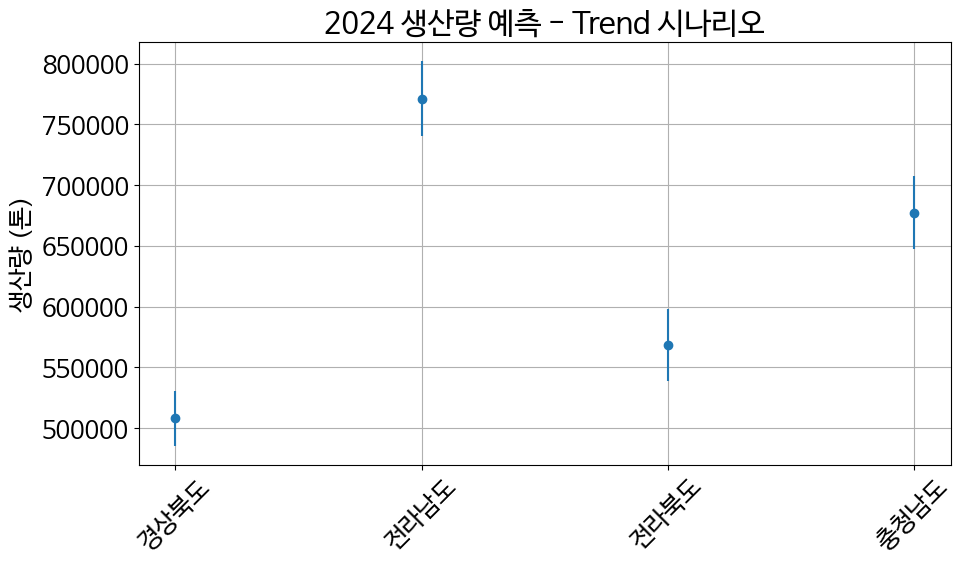


📊 2024년 예측 - 평균 기후 시나리오
----------------------------------------------------------------------
※ 단위: 톤
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량
0  경상북도  508,577  481373.35  535780.03   93835.04       5.42
1  전라남도  771,828  734783.92  808872.33  149890.84       5.15
2  전라북도  576,918  541522.92  612313.96  109012.09       5.29
3  충청남도  667,891  631841.37  703940.13  131360.78       5.08


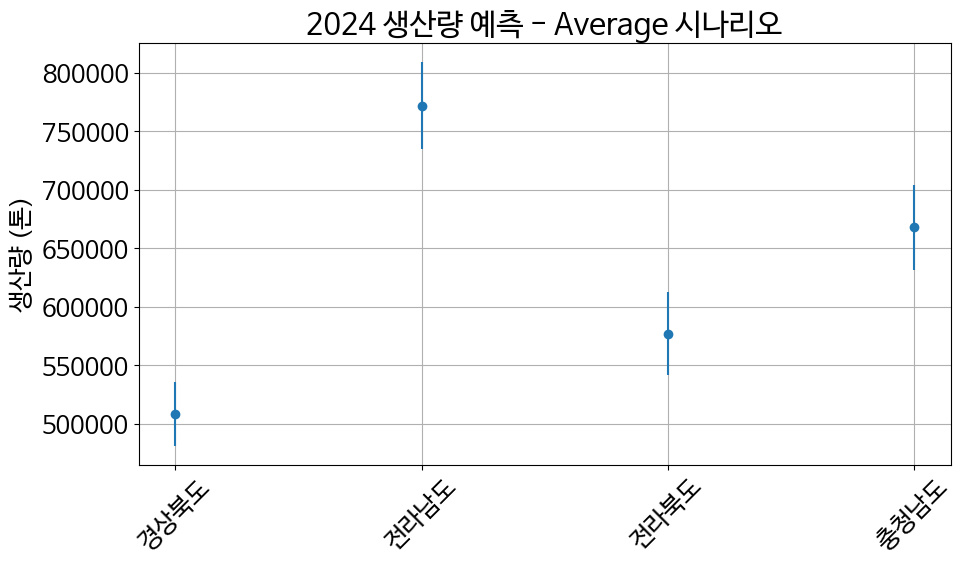


📊 2024년 예측 - 최악 기후 시나리오
----------------------------------------------------------------------
※ 단위: 톤
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량
0  경상북도  515,222  481218.04  549226.39   93835.04       5.49
1  전라남도  768,689  722383.37  814993.88  149890.84       5.13
2  전라북도  588,003  543758.28  632247.09  109012.09       5.39
3  충청남도  668,073  623011.47  713134.91  131360.78       5.09


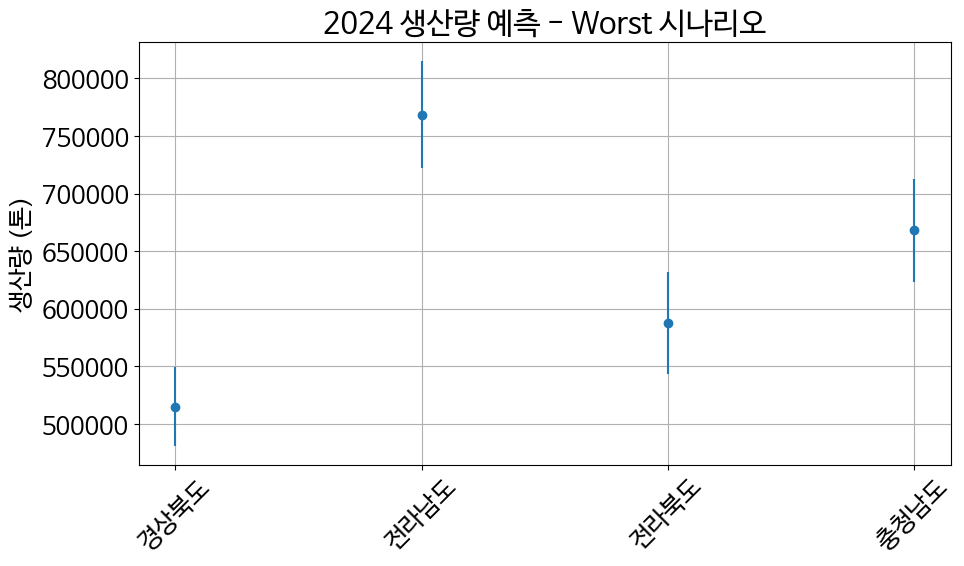


📊 2024년 예측 - 최적 기후 시나리오
----------------------------------------------------------------------
※ 단위: 톤
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량
0  경상북도  508,671  479200.25  538140.82   93835.04       5.42
1  전라남도  771,246  731114.72  811377.16  149890.84       5.15
2  전라북도  577,111  538765.41  615455.71  109012.09       5.29
3  충청남도  667,410  628357.01  706463.99  131360.78       5.08


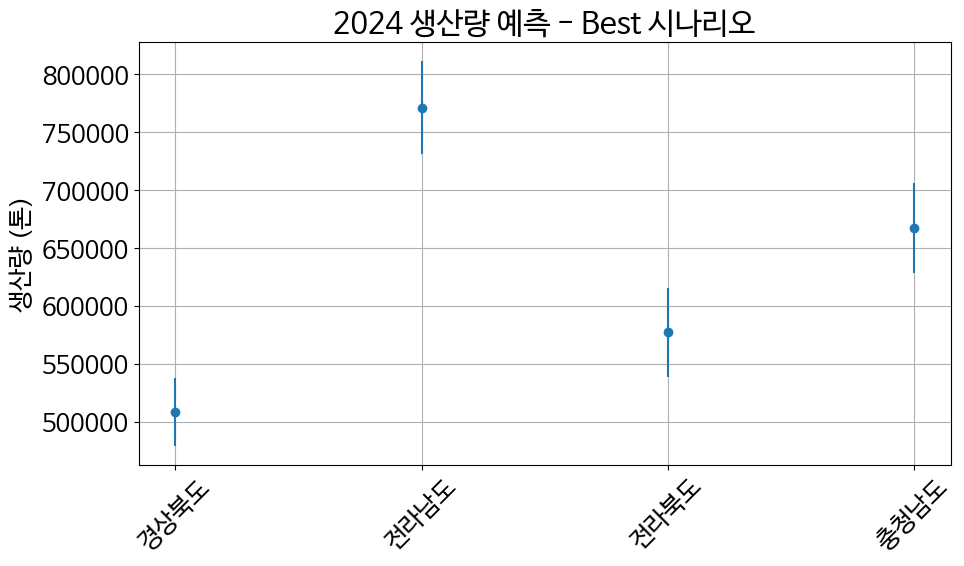


🔮 2025년 장기 예측 분석 (추세 기반)

지역별 예측 결과:
--------------------------------------------------------------------------------
▶ 경상북도
   - 2025년 예상 생산량:         508,453 톤
   - 2024년 예상 생산량:         508,299 톤
   - 전년대비 변화율:               0.03 %
   - 재배면적:                 93,741.93 ha
   - 단위면적당 생산량:             5.42 톤/ha
--------------------------------------------------------------------------------
▶ 전라남도
   - 2025년 예상 생산량:         771,068 톤
   - 2024년 예상 생산량:         771,088 톤
   - 전년대비 변화율:              -0.00 %
   - 재배면적:                148,899.35 ha
   - 단위면적당 생산량:             5.18 톤/ha
--------------------------------------------------------------------------------
▶ 전라북도
   - 2025년 예상 생산량:         563,793 톤
   - 2024년 예상 생산량:         568,326 톤
   - 전년대비 변화율:              -0.80 %
   - 재배면적:                108,450.26 ha
   - 단위면적당 생산량:             5.20 톤/ha
--------------------------------------------------------------------------------
▶ 충청남도
   - 2025년 예상 생산량:         677,396 톤
   - 2024

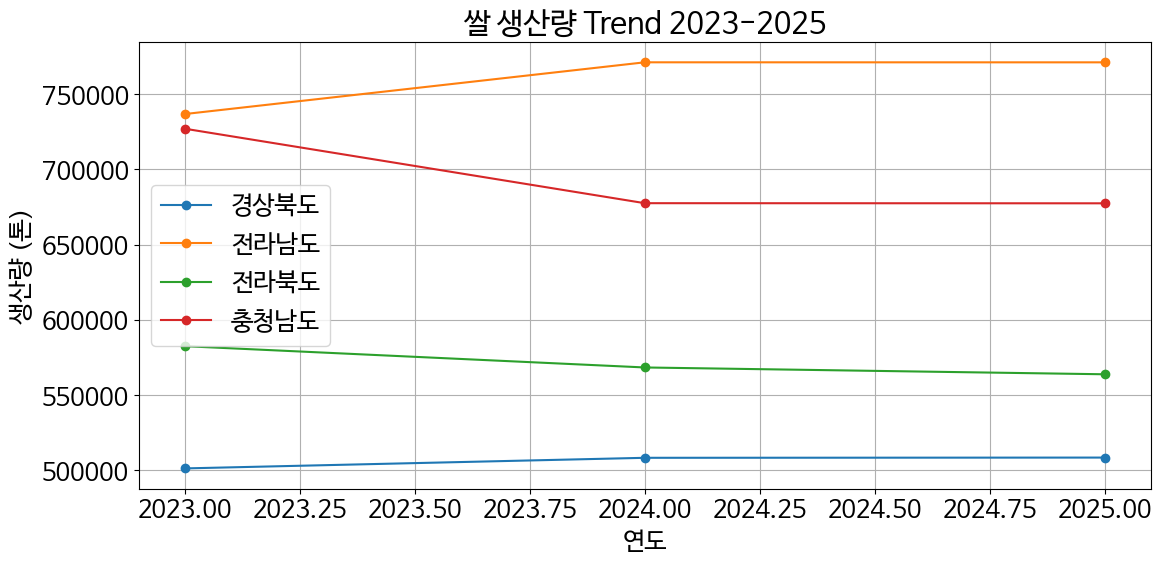

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

class RiceProductionPredictor:
    def __init__(self):
        """데이터 로드 및 초기화"""
        try:
            # 데이터 로드
            self.rice_data = pd.read_excel('/content/filtered_rice_production.xlsx')
            self.climate_annual = pd.read_csv('/content/filtered_climate_annual_data.csv')
            self.climate_monthly = pd.read_csv('/content/filtered_climate_monthly_data.csv')

            self.processed_data = None
            self.model = None
            self.scaler = StandardScaler()
            self.feature_columns = None

        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {str(e)}")
            raise

    def prepare_data(self):
        """데이터 전처리"""
        try:
            # 연간 기후 데이터 처리 - 각 행정구역별 평균
            climate_annual_mean = self.climate_annual.groupby(['행정구역', '일시']).agg({
                '평균기온(°C)': 'mean',
                '합계 강수량(mm)': 'sum',
                '평균 상대습도(%)': 'mean',
                '합계 일조시간(hr)': 'mean'
            }).reset_index()

            # 월별 기후 데이터 처리
            self.climate_monthly['연도'] = self.climate_monthly['일시'].str.split('-').str[0].astype(int)
            self.climate_monthly['월'] = self.climate_monthly['일시'].str.split('-').str[1].astype(int)

            # 월별 데이터 피봇 테이블 생성 (한 번에 하나의 측정값만 처리)
            pivot_dfs = []
            measures = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']

            for measure in measures:
                pivot_df = pd.pivot_table(
                    self.climate_monthly,
                    values=measure,
                    index=['행정구역', '연도'],
                    columns='월',
                    aggfunc='mean' if measure == '평균기온(°C)' or measure == '평균 상대습도(%)' else 'sum'
                ).reset_index()

                # 컬럼명 변경
                pivot_df.columns = [str(col) if isinstance(col, int) else col for col in pivot_df.columns]
                pivot_df.columns = [f"{measure}_{col}월" if col.isdigit() else col for col in pivot_df.columns]

                pivot_dfs.append(pivot_df)

            # 모든 피벗 테이블 병합
            climate_monthly_pivot = pivot_dfs[0]
            for df in pivot_dfs[1:]:
                climate_monthly_pivot = pd.merge(
                    climate_monthly_pivot,
                    df,
                    on=['행정구역', '연도'],
                    how='inner'
                )

            # 연도 컬럼명 변경
            climate_monthly_pivot = climate_monthly_pivot.rename(columns={'연도': '일시'})

            # 데이터 병합
            merged_data = pd.merge(
                self.rice_data,
                climate_annual_mean,
                on=['행정구역', '일시'],
                how='left'
            )

            self.processed_data = pd.merge(
                merged_data,
                climate_monthly_pivot,
                on=['행정구역', '일시'],
                how='left'
            )

            # 이전 연도 데이터 추가
            self.processed_data['이전년도_생산량'] = self.processed_data.groupby('행정구역')['생산량(톤)'].shift(1)
            self.processed_data['이전년도_재배면적'] = self.processed_data.groupby('행정구역')['재배면적(ha)'].shift(1)

            # 결측치 제거
            self.processed_data = self.processed_data.dropna()

            # 범주형 변수 처리
            self.processed_data = pd.get_dummies(self.processed_data, columns=['행정구역'], prefix='지역')

            return self.processed_data

        except Exception as e:
            print(f"데이터 전처리 중 오류 발생: {str(e)}")
            print("\n현재 데이터 상태:")
            print("기후 월별 데이터 shape:", self.climate_monthly.shape)
            print("기후 연간 데이터 shape:", climate_annual_mean.shape if 'climate_annual_mean' in locals() else "Not created")
            raise

    def train_model(self, target_year=2023):
          """모델 학습"""
          try:
              # 데이터 준비
              data = self.prepare_data()

              # 학습 데이터와 테스트 데이터 분리
              train_data = data[data['일시'] < target_year]
              test_data = data[data['일시'] == target_year]

              if len(test_data) == 0:
                  raise ValueError(f"{target_year}년 데이터가 없습니다.")

              # 특성과 타겟 분리
              self.feature_columns = [col for col in data.columns
                                    if col not in ['생산량(톤)', '일시']]
              X_train = train_data[self.feature_columns]
              y_train = train_data['생산량(톤)']
              X_test = test_data[self.feature_columns]
              y_test = test_data['생산량(톤)']

              # print("\n학습 데이터 크기:", X_train.shape)
              # print("테스트 데이터 크기:", X_test.shape)

              # 특성 스케일링
              X_train_scaled = self.scaler.fit_transform(X_train)
              X_test_scaled = self.scaler.transform(X_test)

              # 모델 학습
              self.model = XGBRegressor(
                  n_estimators=100,
                  learning_rate=0.1,
                  max_depth=5,
                  random_state=42
              )
              self.model.fit(X_train_scaled, y_train)

              # 예측 및 평가
              y_pred = self.model.predict(X_test_scaled)

              # 평가 지표 계산
              mse = mean_squared_error(y_test, y_pred)
              rmse = np.sqrt(mse)
              r2 = r2_score(y_test, y_pred)
              mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

              # 원본 지역명 복원
              region_columns = [col for col in test_data.columns if col.startswith('지역_')]
              region_mapping = test_data[region_columns].idxmax(axis=1).map(lambda x: x.replace('지역_', ''))

              # 결과 데이터프레임 생성
              results = pd.DataFrame({
                  '행정구역': region_mapping,
                  '실제_생산량': y_test,
                  '예측_생산량': y_pred,
                  '오차': y_pred - y_test,
                  '오차율(%)': ((y_pred - y_test) / y_test) * 100
              })

              # 특성 중요도 계산
              feature_importance = pd.DataFrame({
                  'feature': self.feature_columns,
                  'importance': self.model.feature_importances_
              }).sort_values('importance', ascending=False)

              return results, {'RMSE': rmse, 'R2': r2, 'MAPE': mape}, feature_importance

          except Exception as e:
              print(f"모델 학습 중 오류 발생: {str(e)}")
              raise

    def predict_future(self, future_year, scenario='trend'):
        """쌀 재배시기를 고려한 미래 생산량 예측"""
        try:
            if not self.model:
                raise ValueError("모델이 학습되지 않았습니다. 먼저 train_model을 실행하세요.")

            # 재배시기별 기후 변수 가중치 정의
            growing_seasons = {
                '육묘기': {
                    'months': [3, 4],  # 3-4월
                    'weight': 1.2,
                    'critical_vars': ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)']
                },
                '모내기': {
                    'months': [5],     # 5월
                    'weight': 1.5,
                    'critical_vars': ['평균기온(°C)', '합계 강수량(mm)']
                },
                '생육기': {
                    'months': [6, 7, 8],  # 6-8월
                    'weight': 1.3,
                    'critical_vars': ['평균기온(°C)', '합계 강수량(mm)', '합계 일조시간(hr)']
                },
                '출수기': {
                    'months': [8, 9],  # 8-9월
                    'weight': 1.4,
                    'critical_vars': ['평균기온(°C)', '합계 일조시간(hr)']
                },
                '등숙기': {
                    'months': [9, 10],  # 9-10월
                    'weight': 1.3,
                    'critical_vars': ['평균기온(°C)', '합계 일조시간(hr)', '평균 상대습도(%)']
                }
            }

            # 지역 목록 가져오기
            region_columns = [col for col in self.processed_data.columns if col.startswith('지역_')]
            regions = [col.replace('지역_', '') for col in region_columns]

            predictions = []

            for region in regions:
                # 해당 지역의 데이터
                region_mask = self.processed_data[f'지역_{region}'] == 1
                region_data = self.processed_data[region_mask].copy()
                latest_data = region_data.iloc[-1:].copy()

                if len(latest_data) == 0:
                    print(f"경고: {region}의 최근 데이터가 없습니다.")
                    continue

                latest_data['일시'] = future_year

                # 시나리오별 데이터 처리 전 기후 변수 컬럼 목록 생성
                climate_cols = []
                for season_info in growing_seasons.values():
                    for var in season_info['critical_vars']:
                        for month in season_info['months']:
                            col = f"{var}_{month}월"
                            if col in region_data.columns:
                                climate_cols.append(col)

                # 시나리오별 기후 데이터 처리
                if scenario == 'trend':
                    for col in climate_cols:
                        # 연간 추세 계산 (차수를 2로 증가)
                        years = region_data['일시'].values
                        values = region_data[col].values
                        trend = np.polyfit(years, values, deg=2)
                        projected_value = np.polyval(trend, future_year)
                        latest_data[col] = projected_value

                elif scenario == 'worst':
                    for col in climate_cols:
                        if '기온' in col:
                            if any(str(m) in col for m in [6, 7, 8]):  # 생육기 고온
                                latest_data[col] = region_data[col].max() * 1.2
                            else:
                                latest_data[col] = region_data[col].max() * 1.1
                        elif '강수량' in col:
                            if any(str(m) in col for m in [5]):  # 모내기철 가뭄
                                latest_data[col] = region_data[col].min() * 0.7
                            elif any(str(m) in col for m in [9]):  # 수확기 강우
                                latest_data[col] = region_data[col].max() * 1.4
                            else:
                                latest_data[col] = region_data[col].quantile(0.9)
                        elif '일조시간' in col:
                            latest_data[col] = region_data[col].min() * 0.8
                        else:  # 상대습도
                            latest_data[col] = region_data[col].max() * 1.2

                elif scenario == 'best':
                    # 최근 5년 중 최고 수확량 년도 찾기
                    recent_data = region_data.tail(5)
                    best_year = recent_data.loc[recent_data['생산량(톤)'].idxmax(), '일시']
                    best_climate = recent_data[recent_data['일시'] == best_year]

                    for col in climate_cols:
                        optimal_value = best_climate[col].iloc[0]
                        # 최적 조건에 약간의 개선을 가정
                        if '기온' in col:
                            latest_data[col] = optimal_value * 1.05
                        elif '강수량' in col:
                            latest_data[col] = optimal_value * 1.1
                        elif '일조시간' in col:
                            latest_data[col] = optimal_value * 1.15
                        else:  # 상대습도
                            latest_data[col] = optimal_value * 1.02

                else:  # 'average' scenario
                    # 최근 3년 평균 사용
                    recent_data = region_data.tail(3)
                    for col in climate_cols:
                        seasonal_adjustment = 1.0
                        if '기온' in col:
                            # 월별로 다른 가중치 적용
                            month = int(col.split('_')[1].replace('월', ''))
                            if month in [6, 7, 8]:  # 여름철
                                seasonal_adjustment = 1.1
                            elif month in [12, 1, 2]:  # 겨울철
                                seasonal_adjustment = 0.9
                        latest_data[col] = recent_data[col].mean() * seasonal_adjustment

                # 재배면적 추세 반영 (2차 다항식 사용)
                years = region_data['일시'].values
                areas = region_data['재배면적(ha)'].values
                area_trend = np.polyfit(years, areas, deg=2)
                projected_area = max(0, np.polyval(area_trend, future_year))  # 음수 방지
                latest_data['재배면적(ha)'] = projected_area

                # 이전 연도 데이터 업데이트
                latest_data['이전년도_생산량'] = region_data.iloc[-1]['생산량(톤)']
                latest_data['이전년도_재배면적'] = region_data.iloc[-1]['재배면적(ha)']

                # 예측을 위한 특성 선택 및 스케일링
                X_future = latest_data[self.feature_columns]
                X_future_scaled = self.scaler.transform(X_future)
                pred = self.model.predict(X_future_scaled)[0]

                # 신뢰구간 계산 (시나리오별 불확실성 반영)
                base_std = np.std(region_data['생산량(톤)']) / np.sqrt(len(region_data))
                scenario_uncertainty = {
                    'trend': 1.0,
                    'average': 1.2,
                    'worst': 1.5,
                    'best': 1.3
                }
                confidence_interval = 1.96 * base_std * scenario_uncertainty[scenario]

                predictions.append({
                    '행정구역': region,
                    '예측_생산량': pred,
                    '신뢰구간_하한': max(0, pred - confidence_interval),
                    '신뢰구간_상한': pred + confidence_interval,
                    '재배면적(ha)': latest_data['재배면적(ha)'].iloc[0]
                })

            results_df = pd.DataFrame(predictions)
            results_df['단위면적당_생산량'] = results_df['예측_생산량'] / results_df['재배면적(ha)']

            return results_df

        except Exception as e:
            print(f"미래 예측 중 오류 발생: {str(e)}")
            raise

    def evaluate_predictions(self, y_true, y_pred):
        """예측 결과에 대한 다양한 평가 지표 계산"""
        try:
            # 기본 평가 지표
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            # Adjusted R2 계산
            n = len(y_true)
            p = len(self.feature_columns)
            adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

            # 예측 정확도 분석
            errors = y_true - y_pred
            mean_error = np.mean(errors)
            std_error = np.std(errors)

            # 95% 신뢰구간
            confidence_interval = 1.96 * std_error / np.sqrt(n)

            # 정규성 검정은 샘플 수가 8개 이상일 때만 수행
            if len(y_true) >= 8:
                _, normality_p_value = stats.normaltest(errors)
            else:
                # 샘플 수가 적을 때는 정규성 가정
                normality_p_value = 1.0

            return {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Adjusted_R2': adjusted_r2,
                'MAPE': mape,
                'Mean_Error': mean_error,
                'Std_Error': std_error,
                'Confidence_Interval': confidence_interval,
                'Error_Normality_p_value': normality_p_value,
                'Sample_Size': len(y_true)
            }

        except Exception as e:
            print(f"평가 지표 계산 중 오류 발생: {str(e)}")
            raise

    def plot_growing_season_analysis(self, region=None):
        """생육시기별 기후 영향 시각화"""
        plt.style.use('seaborn')

        # 생육시기 정의
        growing_seasons = {
            '육묘기': [3, 4],
            '모내기': [5],
            '생육기': [6, 7, 8],
            '출수기': [8, 9],
            '등숙기': [9, 10]
        }

        # 기후 변수
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']

        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(2, 2)

        # 1. 생육시기별 기후요소 영향도 히트맵
        ax1 = fig.add_subplot(gs[0, 0])
        impact_data = {}

        for season, months in growing_seasons.items():
            season_impact = {}
            for var in climate_vars:
                cols = [f"{var}_{m}월" for m in months]
                correlation = np.abs(self.processed_data[cols].corrwith(self.processed_data['생산량(톤)'])).mean()
                season_impact[var] = correlation
            impact_data[season] = season_impact

        impact_df = pd.DataFrame(impact_data)
        sns.heatmap(impact_df, annot=True, cmap='YlOrRd', ax=ax1)
        ax1.set_title('생육시기별 기후요소 영향도')

        # 2. 월별 기온 변화 추이
        ax2 = fig.add_subplot(gs[0, 1])
        temp_cols = [col for col in self.processed_data.columns if '평균기온(°C)' in col and '월' in col]

        if region:
            region_data = self.processed_data[self.processed_data[f'지역_{region}'] == 1]
        else:
            region_data = self.processed_data

        months = range(1, 13)
        years = region_data['일시'].unique()[-5:]  # 최근 5년

        for year in years:
            year_data = region_data[region_data['일시'] == year]
            temps = [year_data[f'평균기온(°C)_{m}월'].mean() for m in months]
            ax2.plot(months, temps, marker='o', label=str(year))

        ax2.set_xticks(months)
        ax2.set_xlabel('월')
        ax2.set_ylabel('평균 기온(°C)')
        ax2.set_title('월별 기온 변화 추이 (최근 5년)')
        ax2.legend()
        ax2.grid(True)

        # 3. 강수량 분포 boxplot
        ax3 = fig.add_subplot(gs[1, 0])
        rain_cols = [col for col in self.processed_data.columns if '강수량' in col and '월' in col]
        rain_data = region_data[rain_cols].melt()
        sns.boxplot(x='variable', y='value', data=rain_data, ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
        ax3.set_title('월별 강수량 분포')

        # 4. 일조시간과 생산량의 관계
        ax4 = fig.add_subplot(gs[1, 1])
        sun_cols = [col for col in self.processed_data.columns if '일조시간' in col and '월' in col]
        total_sun = region_data[sun_cols].sum(axis=1)
        ax4.scatter(total_sun, region_data['생산량(톤)'])
        ax4.set_xlabel('연간 총 일조시간')
        ax4.set_ylabel('생산량(톤)')
        ax4.set_title('일조시간과 생산량의 관계')

        plt.tight_layout()
        plt.show()

    def plot_prediction_results(self, predictions_2024, predictions_2025, results_2023):
        """예측 결과 시각화"""
        plt.style.use('seaborn')

        # 1. 시나리오별 2024년 예측 비교
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        scenarios = ['trend', 'average', 'worst', 'best']
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']

        for i, scenario in enumerate(scenarios):
            ax = axes[i//2, i%2]
            predictions = predictions_2024[scenario]

            x = np.arange(len(predictions['행정구역']))

            # 예측값만 표시
            ax.bar(x, predictions['예측_생산량'], color=colors[i], label='예측 생산량')

            # 신뢰구간 표시
            ax.errorbar(x, predictions['예측_생산량'],
                      yerr=[predictions['예측_생산량'] - predictions['신뢰구간_하한'],
                            predictions['신뢰구간_상한'] - predictions['예측_생산량']],
                      fmt='none', color='black', capsize=5)

            ax.set_xticks(x)
            ax.set_xticklabels(predictions['행정구역'])
            ax.set_title(f'{scenario.capitalize()} 시나리오 예측 결과')
            ax.legend()

        plt.tight_layout()
        plt.show()

        # 2. 2023-2025 추세 분석
        plt.figure(figsize=(12, 8))

        for region in results_2023['행정구역'].unique():
            years = [2023, 2024, 2025]
            values = [
                results_2023[results_2023['행정구역'] == region]['실제_생산량'].iloc[0],  # 2023년은 실제값
                predictions_2024['trend'][predictions_2024['trend']['행정구역'] == region]['예측_생산량'].iloc[0],  # 2024년 예측값
                predictions_2025[predictions_2025['행정구역'] == region]['예측_생산량'].iloc[0]  # 2025년 예측값
            ]
            plt.plot(years, values, marker='o', linewidth=2, markersize=8, label=region)

        plt.title('쌀 생산량 추세 분석 (2023-2025)', fontsize=14)
        plt.xlabel('연도', fontsize=12)
        plt.ylabel('생산량(톤)', fontsize=12)
        plt.grid(True)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

        # 3. 지역별 단위면적당 생산량 비교
        plt.figure(figsize=(10, 6))
        for scenario in scenarios:
            data = predictions_2024[scenario]
            plt.plot(data['행정구역'], data['단위면적당_생산량'],
                    marker='o', label=scenario.capitalize())

        plt.title('시나리오별 단위면적당 생산량 비교', fontsize=14)
        plt.xlabel('지역', fontsize=12)
        plt.ylabel('단위면적당 생산량(톤/ha)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()



def main():
    try:
        # 시스템 시작
        print("\n" + "="*70)
        print("                    🌾 쌀 생산량 예측 시스템 🌾")
        print("="*70)
        predictor = RiceProductionPredictor()

        # 2023년 예측 및 평가
        print("\n📊 [2023년 쌀 생산량 예측 분석]")
        print("-"*70)
        results_2023, metrics, feature_importance = predictor.train_model(target_year=2023)

        # 상세 평가 지표 계산
        detailed_metrics = predictor.evaluate_predictions(
            results_2023['실제_생산량'],
            results_2023['예측_생산량']
        )

        # 지역별 예측 결과 출력
        print("\n📍 지역별 예측 결과 분석")
        print("-" * 70)
        print("※ 단위: 톤")
        results_display = results_2023.copy()
        results_display['실제_생산량'] = results_display['실제_생산량'].apply(lambda x: f"{x:,.0f}")
        results_display['예측_생산량'] = results_display['예측_생산량'].apply(lambda x: f"{x:,.0f}")
        print(results_display)

        print("\n📈 모델 성능 평가 지표:")
        print("-" * 70)
        metrics_df = pd.DataFrame([detailed_metrics]).round(4)
        print(metrics_df)

        print("\n🔍 예측 정확도 검증:")
        print("-" * 70)
        print(f"신뢰성 검정 P-값: {detailed_metrics['Error_Normality_p_value']:.4f}")
        if detailed_metrics['Error_Normality_p_value'] > 0.05:
            print("✅ 예측 결과가 통계적으로 신뢰할 수 있는 수준입니다.")
        else:
            print("⚠️ 예측 결과에 일부 편향이 있을 수 있습니다.")

        # 미래 예측
        if detailed_metrics['R2'] > 0.7:
            print("\n🔮 미래 생산량 예측 분석 시작...")

            # 각 시나리오별 2024년 예측
            scenarios = ['trend', 'average', 'worst', 'best']
            scenario_names = {
                'trend': '추세 기반',
                'average': '평균 기후',
                'worst': '최악 기후',
                'best': '최적 기후'
            }
            predictions_2024 = {}

            for scenario in scenarios:
                predictions_2024[scenario] = predictor.predict_future(2024, scenario=scenario)

                print(f"\n📊 2024년 예측 - {scenario_names[scenario]} 시나리오")
                print("-" * 70)
                print("※ 단위: 톤")
                predictions_display = predictions_2024[scenario].copy()
                predictions_display['예측_생산량'] = predictions_display['예측_생산량'].apply(lambda x: f"{x:,.0f}")
                print(predictions_display.round(2))

                # 신뢰구간 시각화
                plt.figure(figsize=(10, 6))
                plt.errorbar(
                    predictions_2024[scenario]['행정구역'],
                    predictions_2024[scenario]['예측_생산량'],
                    yerr=[
                        predictions_2024[scenario]['예측_생산량'] - predictions_2024[scenario]['신뢰구간_하한'],
                        predictions_2024[scenario]['신뢰구간_상한'] - predictions_2024[scenario]['예측_생산량']
                    ],
                    fmt='o'
                )
                plt.title(f'2024 생산량 예측 - {scenario.capitalize()} 시나리오')
                plt.ylabel('생산량 (톤)')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            # 2025년 예측 (trend 시나리오)
            predictions_2025 = predictor.predict_future(2025, scenario='trend')
            comparison_2025 = pd.merge(
                predictions_2025,
                predictions_2024['trend'][['행정구역', '예측_생산량']].rename(
                    columns={'예측_생산량': '2024년_예측'}
                ),
                on='행정구역'
            )
            comparison_2025['변화율(%)'] = (
                (comparison_2025['예측_생산량'] - comparison_2025['2024년_예측'])
                / comparison_2025['2024년_예측'] * 100
            )

            print("\n🔮 2025년 장기 예측 분석 (추세 기반)")
            print("=" * 80)
            print("\n지역별 예측 결과:")
            print("-" * 80)

            for idx, row in comparison_2025.iterrows():
                print(f"▶ {row['행정구역']}")
                print(f"   - 2025년 예상 생산량: {row['예측_생산량']:>15,.0f} 톤")
                print(f"   - 2024년 예상 생산량: {row['2024년_예측']:>15,.0f} 톤")
                print(f"   - 전년대비 변화율:    {row['변화율(%)']:>15.2f} %")
                print(f"   - 재배면적:           {row['재배면적(ha)']:>15,.2f} ha")
                print(f"   - 단위면적당 생산량:  {row['단위면적당_생산량']:>15.2f} 톤/ha")
                print("-" * 80)


            # 추세 시각화
            plt.figure(figsize=(12, 6))
            for region in results_2023['행정구역'].unique():
                years = [2023, 2024, 2025]
                values = [
                    results_2023[results_2023['행정구역'] == region]['실제_생산량'].iloc[0],
                    predictions_2024['trend'][predictions_2024['trend']['행정구역'] == region]['예측_생산량'].iloc[0],
                    predictions_2025[predictions_2025['행정구역'] == region]['예측_생산량'].iloc[0]
                ]
                plt.plot(years, values, marker='o', label=region)

            plt.title('쌀 생산량 Trend 2023-2025')
            plt.xlabel('연도')
            plt.ylabel('생산량 (톤)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        else:
            print("\n⚠️ 경고: 모델의 예측 정확도가 기준치(R2 > 0.7)에 미달하여 미래 예측을 수행할 수 없습니다.")

    except Exception as e:
        print(f"\n❌ 시스템 오류 발생: {str(e)}")
        print("프로그램을 다시 실행해주세요.")
        raise

if __name__ == "__main__":
    main()